# Basic setup

Here we will import the `pyspark` module and set up a `SparkSession`.  By default, we'll use a `SparkSession` running locally, with one Spark executor for every core on the local machine.  You can change this to run against a Spark cluster by replacing `local[*]` with the URL of the Spark master.


In [1]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

# Creating a resilient distributed dataset (RDD)

One of the easiest ways to create a resilient distributed dataset is from a local collection, with the `parallelize` method on the `SparkContext` object.

In [2]:
numberRDD = sc.parallelize(range(1, 10000))

You can also create RDDs from files, S3 objects, and other external data sources.  See [the documentation](https://spark.apache.org/docs/latest/programming-guide.html#external-datasets) for more information. 

# Basic RDD transformations 

RDDs are _immutable_, so to transform a RDD, we create a new one.  RDDs are also _lazy_, so instead of transforming the elements when we create the new RDD, we store a reference to the original and the operation we'd need to apply to it to construct the transformed RDD.

In [3]:
# filter numberRDD, keeping only even numbers
evens = numberRDD.filter(lambda x: x % 2 == 0)

# produce an RDD by doubling every element in numberRDD
doubled = numberRDD.map(lambda x: x * 2)

# filter numberRDD, keeping only multiples of five
fives = numberRDD.filter(lambda x: x % 5 == 0)

# return an RDD of the elements in both evens and fives
tens = evens.intersection(fives)
sortedTens = tens.sortBy(lambda x: x)

You can see other RDD transformations in the [Spark documentation](https://spark.apache.org/docs/latest/programming-guide.html#transformations).

# RDD actions

Since RDDs are lazy and RDD transformations don't actually compute anything, we need some way to force Spark to actually schedule a computation.  RDD _actions_ are operations that schedule the graph of computations implied by an RDD and return a result to the main program.  Here are a few examples:

In [4]:
(evens.count(), doubled.count())

(4999, 9999)

In [5]:
# note that we may not get results in order!
tens.take(5)

[8320, 2080, 4160, 480, 8800]

In [6]:
# ...unless we sort
sortedTens.take(5)

[10, 20, 30, 40, 50]

In [7]:
# we can take a sample from an RDD (with or without replacement)
sortedTens.takeSample(False, 10)

[8220, 7810, 1830, 6440, 4960, 5210, 3030, 9730, 5190, 690]

In [8]:
sortedTens.reduce(lambda x, y: max(x, y))

9990

You can see some other RDD actions in the [Spark documentation](https://spark.apache.org/docs/latest/programming-guide.html#actions).

# Structured query and data frames

Spark also includes support for structured queries, including SQL and pandas- or R-like "data frame" operations through a query DSL.

Let's see structured query in action by loading a [Parquet](http://parquet.apache.org/) file with some simplified [fedmsg](https://fedora-fedmsg.readthedocs.io/en/latest/) log messages.

In [9]:
df = spark.read.load("/data/msgs.parquet")
df.printSchema()

root
 |-- category: string (nullable = true)
 |-- i: long (nullable = true)
 |-- id: long (nullable = true)
 |-- msg: string (nullable = true)
 |-- msg_id: string (nullable = true)
 |-- source_name: string (nullable = true)
 |-- source_version: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- topic: string (nullable = true)



We can use the data frame DSL to do RDBMS-style queries on these data, which is great for characterizing or exploring it.  Because these queries can execute in parallel or across multiple machines, aggregations can be _much_ faster in Spark than they are on a traditional RDBMS.  

It is simple to do basic aggregations, like this:

In [10]:
df.groupBy('category').count().orderBy('count', ascending=False).show()

+------------+-------+
|    category|  count|
+------------+-------+
|    buildsys|3494565|
|         git|  92611|
|        copr|  76774|
|       pkgdb|  43328|
|       bodhi|  33624|
|fedoratagger|  30835|
|   fedbadges|  29494|
|        wiki|  17609|
|      askbot|  15278|
|         fas|  13022|
|  summershum|   6996|
|        trac|   6496|
|     compose|   5340|
|        null|   5095|
|     ansible|   4333|
|      github|   4291|
|      planet|   3926|
|     meetbot|   3016|
|      anitya|   1300|
|         fmn|    817|
+------------+-------+
only showing top 20 rows



(This file isn't huge, but it's in the Docker image.)

In [11]:
df.count()

3889881

We can use the `show` method to quickly inspect a few rows of a data frame (not just the results of a query).  This is often helpful to sanity-check a new data source.

In [12]:
df.show(10)

+--------+---+--------+--------------------+--------------------+-----------+--------------+--------------------+--------------------+
|category|  i|      id|                 msg|              msg_id|source_name|source_version|           timestamp|               topic|
+--------+---+--------+--------------------+--------------------+-----------+--------------+--------------------+--------------------+
|buildsys|  1|14261348|{"build_id":22449...|2014-9c2aa45d-5e8...| datanommer|         0.6.4|2014-10-10T21:11:...|org.fedoraproject...|
|buildsys|  2|14261349|{"build_id":22456...|2014-7db189aa-0ff...| datanommer|         0.6.4|2014-10-10T21:11:...|org.fedoraproject...|
|buildsys| 12|14261359|{"build_id":22312...|2014-14a4b71c-d5a...| datanommer|         0.6.4|2014-10-10T21:11:...|org.fedoraproject...|
|buildsys| 17|14261364|{"build_id":22731...|2014-e0cb85f1-22c...| datanommer|         0.6.4|2014-10-10T21:11:...|org.fedoraproject...|
|buildsys| 32|14261379|{"build_id":22297...|2014-9e430f

# Data cleaning

Uh oh!  It looks like the `msg` field of this data frame is JSON-encoded message structures instead of actual message structures.  While we'd _never_ see messy data in the real world, this really throws a wrench into our tutorial.  Let's fix that by asking Spark to infer a schema for the JSON fields.

In [13]:
msgRDD = df.select("msg").rdd.map(lambda x: x[0])
# structs = sqlc.jsonRDD(msgRDD)
# structs.printSchema()

You'll notice that the last two lines are commented out there, and with good reason.  You can uncomment them and run them, but only if you're patient and willing to scroll. You'll get a huge schema with objects that have one field for (as one example) every Fedora user who has ever participated in an IRC meeting! (Alternatively, [click here](https://gist.github.com/willb/ede22cdcd25b64e8cda952f927701d96) to see a rendered version of the inferred schema.) 

Spark can't infer a useful schema for these JSON records, because their schemas diverge and because of some of the unusual ways that `fedmsg` data uses JSON to encode maps.  While there are a few reasons for the schema divergence (see [a practical treatment](http://chapeau.freevariable.com/2014/10/fedmsg-and-spark.html) or a more [type-theoretic one](http://chapeau.freevariable.com/2014/11/algebraic-types.html)), in this case one problem is that different `fedmsg` messages use the `branches` field to refer to values with incompatible types.

Fortunately, we can fix that with a pretty quick hack.  We'll just go through every record and retain only a few fields that we know are not going to give us grief.  (You'd probably want to do something more sophisticated in a real application.)  We'll use Spark's _user-defined function_ mechanism to achieve this.

In [14]:
import json

# define the fields we want to keep
interesting_fields = ['agent', 'author', 'copr', 'user', 'msg', 'meeting_topic', 'name', 'owner', 'package']

# describe the return type of our user-defined function
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
resultType = StructType([StructField(f, StringType(), nullable=True) for f in interesting_fields])

# this is the body of our first user-defined function, to restrict us to a subset of fields
def trimFieldImpl(js):
    try:
        d = json.loads(js)
        return [d.get(f) for f in interesting_fields]
    except:
        # return an empty struct if we fail to parse this message
        return [None] * len(interesting_fields)
    
from pyspark.sql.functions import udf

# register trimFieldImpl as a user-defined function
trimFields = udf(trimFieldImpl, resultType)

trimmedDF = df.withColumn("msg", trimFields("msg"))

In [15]:
trimmedDF.printSchema()

root
 |-- category: string (nullable = true)
 |-- i: long (nullable = true)
 |-- id: long (nullable = true)
 |-- msg: struct (nullable = true)
 |    |-- agent: string (nullable = true)
 |    |-- author: string (nullable = true)
 |    |-- copr: string (nullable = true)
 |    |-- user: string (nullable = true)
 |    |-- msg: string (nullable = true)
 |    |-- meeting_topic: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- owner: string (nullable = true)
 |    |-- package: string (nullable = true)
 |-- msg_id: string (nullable = true)
 |-- source_name: string (nullable = true)
 |-- source_version: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- topic: string (nullable = true)



Data frames are a great way to explore structured data, but you can also train models against them (either by converting to RDDs and using [MLlib](https://spark.apache.org/docs/latest/mllib-guide.html) or by using [ML Pipelines](https://spark.apache.org/docs/latest/ml-guide.html) to define learning pipelines directly on data frames).

Let's extract bug and update comments from our `fedmsg` data and use those to train a word2vec model.

In [16]:
def getComments(js):
    try:
        # construct a dict from the json string
        # we care about the following paths:  
        # * /comment/text 
        # * /notes/
        # * /update/comments//text
        d = json.loads(js)
        comment = [d.get('comment', {})]
        notes = d.get('notes', [])
        update_comments =  d.get('update', {}).get('comments', [])
        comment_texts = [c['text'] for c in comment + update_comments if 'text' in c]
        return comment_texts + notes
    except:
        return[]

commentsRDD = msgRDD.flatMap(lambda js: getComments(js))

# Turn comments into sequences of words.  Convert everything 
# to lowercase first to avoid spurious "synonyms" between differently-
# capitalized words (but try this also without `w.lower()` and see how 
# your results change!)
#
# We won't bother stripping punctuation or stemming but while we're in
# #YOLO territory for a tutorial and demo, you'd surely want to do 
# something more sensible in a real application.
wordSeqs = commentsRDD.map(lambda s: [w.lower() for w in s.split()])

In [17]:
# actually train a model

from pyspark.mllib.feature import Word2Vec

w2v = Word2Vec()
model = w2v.fit(wordSeqs)

# find synonyms for a given word
synonyms = model.findSynonyms('works', 5)

for word, distance in synonyms:
    print("{}: {}".format(word, distance))

working: 0.791810629272
work: 0.746105223205
worked: 0.699443280518
as: 0.68381324218
thanks: 0.666000618795


In [18]:
# see some of the words in the model

list(model.getVectors().keys())[:20]

[u'breaks',
 u'(fedora)',
 u'yaneti.',
 u'immanetize.',
 u'hpejakle.',
 u'submitted',
 u'plugin',
 u'looks',
 u'alpha',
 u'kkeithle.',
 u'tgl.',
 u'packages,',
 u'jdunn.',
 u'nalin',
 u'used',
 u'automatic',
 u'great.',
 u'mystro256.',
 u'oget.',
 u'frafra.']

# Some exercises:

1.  Try running the word2vec pipeline above without converting words to lowercase (you can eliminate the list comprehension or change `w.lower()` to `w`).  How does this change your results?
2.  Try eliminating punctuation from words (use a regular expression).  You may also want to remove _stopwords_, or extremely common words (like articles, prepositions, conjunctions, etc.), and the `StopWordsRemover` class in Spark will remove stopwords from prose in several languages.  Check the documentation for details on how to use it (you'll want to use the MLlib version and not the `spark.ml` version since we're working with RDDs and not data frames).  Run your model and some queries after each step.  Do the additional data cleaning steps improve your results?  If not, why do you suppose the results change?
3.  You may also be interested in stemming your words (e.g. converting "works", "worked", "working", "worker" to "work").  While you can also use a regular expression for this, you may find it's more productive to use an external library.  Consider using the [NLTK](http://nltk.org) package, which provides a sensible text tokenizer and a stemmer, among other tools for natural language processing.
4.  The synonym query is interesting, but the word2vec model also supports finding analogies through linear transformations, for example, in a word2vec model trained on general English text, the vector for "king" plus the vector for "woman" minus the vector for "man" will be very similar to the vector for "queen".  While the training corpus we have with a subset of fedmsg messages is far, far, smaller than we'd want to use for a general model, you may want to play with this and see how it works.  You can use `getVectors()` to get the vectors for particular words, `numpy` for the vector transformations, and then you can pass a vector to the `findSynonyms()` method to see which words have vectors closest to a given vector.

&nbsp;

&nbsp;

&nbsp;

Great work!  Now that you're comfortable with Spark, let's try using it to set up a financial simulation

# Value-at-risk calculations

The basic idea behind the value-at-risk calculation is that we're going to look at the historical returns of a portfolio of securities and run many simulations to determine the range of returns we can expect from these.  We can then predict, over a given time horizon, what our expected loss is at a given probability, e.g., we might say that there is less than a 10% chance that the portfolio will lose more than $1,000,000.

Note that this is a didactic example and consequently makes some simplifying assumptions about the composition of the portfolio (i.e., only long positions in common stocks, so no options, dividends, or short selling) and the behavior of the market (i.e., day-to-day return percentages are normally-distributed and independent).  Do not use this code to guide actual investment decisions!

## Basic setup

Here we import the `pyspark` module and set up a `SparkSession`.

In [22]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.master("local[*]").getOrCreate()

## Loading the data

We'll start by loading the data (from the WikiEOD dataset of freely-available stock closing prices).

In [23]:
df = spark.read.load("/data/wikieod.parquet")

## Calculating historical returns

We'll use Spark's windowing functions over data frames to determine the percentage change in each security from the previous close to each day's close.  Basically, we'll add a column to our data frame that represents the percentage change from the previous day's close (that is, `lag("close", 1)` when partitioned by ticker symbol and ordered by date) and the current day's close (that is, `col("close")`).

In [24]:
from pyspark.sql import Window
from pyspark.sql.functions import lag, col, avg, variance

ddf = df.select("ticker", "date", "close").withColumn("change", (col("close") / lag("close", 1).over(Window.partitionBy("ticker").orderBy(df["date"])) - 1.0) * 100)
ddf.show(10)

+------+----------+-----+------------------+
|ticker|      date|close|            change|
+------+----------+-----+------------------+
|  ACFN|1992-02-11|10.12|              null|
|  ACFN|1992-02-12|10.75| 6.225296442687744|
|  ACFN|1992-02-13| 10.0|-6.976744186046513|
|  ACFN|1992-02-14|10.12| 1.200000000000001|
|  ACFN|1992-02-18|10.25|1.2845849802371578|
|  ACFN|1992-02-19|10.38|1.2682926829268304|
|  ACFN|1992-02-20| 12.0|15.606936416184958|
|  ACFN|1992-02-21|13.12| 9.333333333333327|
|  ACFN|1992-02-24| 12.0|-8.536585365853655|
|  ACFN|1992-02-25|12.38| 3.166666666666673|
+------+----------+-----+------------------+
only showing top 10 rows



## Characterizing expected return distributions

With the range of changes now available, we can calculate our expected returns for each security.  Since this is a simple example, we'll assume that returns are normal (in the real world, you'd want to use a distribution with heavier tails or a more sophisticated technique altogether).  We can calculate the parameters for each security's distribution as follows:

In [25]:
from pyspark.sql.functions import sqrt
mv = ddf.groupBy("ticker").agg(avg("change").alias("mean"), sqrt(variance("change")).alias("stddev"))
mv.show(10)

+------+--------------------+------------------+
|ticker|                mean|            stddev|
+------+--------------------+------------------+
|  ACFN| 0.06242424778074286| 5.014939329411184|
|  ALXN| 0.15393095850020602| 4.532013447331393|
|  AWAY| 0.02539756867869776|  2.69393746555018|
|   CCK| 0.04952646560952892| 2.931715455254924|
|   CRS|0.031102171093862575| 2.499932187771903|
|  CYNI|-0.03118042941995...|4.1279080205519225|
|   GIS|0.019429696808146178| 1.721249863186511|
|  HBNC|0.027071069371644215|2.0340790030584697|
|  HWAY| 0.08017011008855986| 3.668783283957359|
|     K|0.026071743393784257|1.8036206811619875|
+------+--------------------+------------------+
only showing top 10 rows



Since there are only about 3,000 ticker symbols in our data set, we can easily collect these in driver memory for use in our simulation:

In [26]:
dist_map = mv.rdd.map(lambda r: (r[0], (r[1], r[2]))).collectAsMap()
dist_map["RHT"]

(0.08187986469765945, 3.8769620645490304)

## Getting current security prices

We'll now identify the latest price for each security in our dataset:

In [27]:
from pyspark.sql.functions import first
priceDF = ddf.orderBy("date", ascending=False).groupBy("ticker").agg(first("close").alias("price"), first("date").alias("date")).cache()
priceDF.show(10)

prices = priceDF.rdd.map(lambda r: (r[0], r[1])).collectAsMap()

+------+-----+----------+
|ticker|price|      date|
+------+-----+----------+
|  ACFN| 0.26|2015-07-23|
|  ALXN|129.0|2016-11-04|
|  AWAY|35.77|2015-12-14|
|   CCK|53.04|2016-11-04|
|   CRS|31.75|2016-11-04|
|  CYNI|  5.7|2015-07-31|
|   GIS|60.65|2016-11-04|
|  HBNC|27.59|2016-11-04|
|  HWAY|19.45|2016-11-04|
|     K|73.67|2016-11-04|
+------+-----+----------+
only showing top 10 rows



## Setting up a simulation

We'll now define our simulation.  This involves three steps: 

1.  We'll start by generating a random portfolio of securities (a map from ticker symbols to values); then, 
2.  we'll decide how many simulations to run and generate a random seed for each; and, finally
3.  we'll actually run the simulation for a given number of training days, updating the value of our portfolio with random returns sampled from the distribution of historical returns.

Generating the random portfolio is pretty straightforward:

In [28]:
from random import randint, seed

def random_portfolio(symbols):
    result = {}
    for s in symbols:
        result[s] = prices[s] * (randint(1, 1000) * 11)
    return result

def portfolio_value(pf):
    return sum([v for v in pf.values()])

seed(0xdea110c8)

portfolio = random_portfolio(ddf.select("ticker").distinct().sample(True, 0.01, 0xdea110c8).rdd.map(lambda r: r[0]).collect())

As is generating a collection of random seeds:

In [29]:
def seeds(count):
    return [randint(0, 1 << 32 - 1) for i in range(count)]

We'll define a single step of our simulation (and, subsequently, a whole run of the simulation) next:

In [30]:
def simstep(pf, params, prng):
    def daily_return(sym):
        mean, stddev = params[sym]
        change = (prng.normalvariate(mean, stddev) + 100) / 100.0
        return change
    return dict([(s, daily_return(s) * v) for s, v in pf.items()])

def simulate(seed, pf, params, days):
    from random import Random
    prng = Random()
    prng.seed(seed)
    pf = pf.copy()
    
    for day in range(days):
        pf = simstep(pf, params, prng)
    return pf

Now we have everything we need to actually run the simulation.  For each seed, we'll spawn a Spark job to simulate 5 days of activity on our portfolio and then return the total dollar value of our gain or loss at the end of the period.

In [31]:
days_to_simulate = 5
simulation_count = 10000

sc = spark.sparkContext
seed_rdd = sc.parallelize(seeds(simulation_count))
bparams = sc.broadcast(dist_map)
bpf = sc.broadcast(portfolio)
initial_value = portfolio_value(portfolio)

results = seed_rdd.map(lambda s: portfolio_value(simulate(s, bpf.value, bparams.value, days_to_simulate)) - initial_value)

In [32]:
simulated_results = list(zip(results.collect(), seed_rdd.collect()))
simulated_values = [v for (v, _) in simulated_results]
simulated_values.sort()

/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


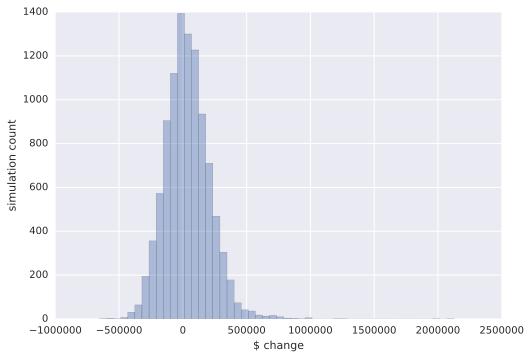

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import numpy as np
sns.set(color_codes=True)

_ = sns.distplot(simulated_values, kde=False).set(xlabel="$ change", ylabel="simulation count")


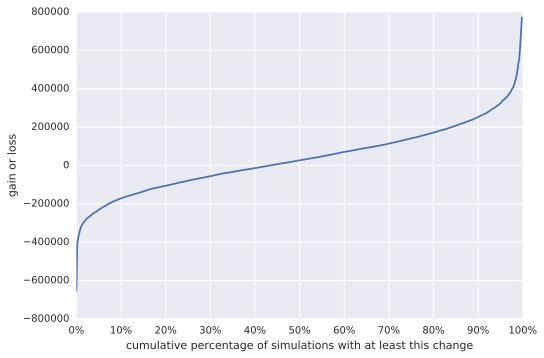

In [35]:
# plot only every 20th simulation result (unless that would leave us with fewer 
# than 50 elements) to avoid generating a huge figure
plotevery = len(simulated_values) > 1000 and 20 or 1

xvals = [float(i) / len(simulated_values) for i in range(len(simulated_values))]
ax = sns.tsplot(np.array(simulated_values[::plotevery]), np.array(xvals[::plotevery]))

# add ticks for every ten percent
ax.get_xaxis().set_ticks([i * 0.1 for i in range(11)])
_ = ax.get_xaxis().set_ticklabels(["%d%%" % (i * 10) for i in range(11)])

_ = ax.set(xlabel="cumulative percentage of simulations with at least this change", ylabel="gain or loss")

Since the market historically trends up, we have a better than even chance of not losing money in our simulation.  We can see the 5% value at risk over our time horizon by taking the corresponding element out of the sorted simulation results.

In [36]:
# 5% value at risk
percentage_var = 0.05

simulated_values[int(len(simulated_values) * percentage_var)]

-230842.79220493976

## Visualizing random walks

Finally, let's look at some example simulation runs to see how the portfolio value changes over time.  We'll take the runs with the best and worst returns and also the runs at each decile.  To visualize our simulation, we'll need a slightly different `simulate` function:

In [37]:
def simulate_with_history(seed, pf, params, days):
    from random import Random
    prng = Random()
    prng.seed(seed)
    pf = pf.copy()
    values = [portfolio_value(pf)]
    
    for day in range(days):
        pf = simstep(pf, params, prng)
        values.append(portfolio_value(pf))
    return values

We'll now repeat the simulation on eleven of our seeds from the earlier run, collecting history for each:

In [38]:
simulated_results.sort()

# choose the least result, the 10%ile, the 20%ile, ..., the 90%ile, and the greatest result
eleven_results = [simulated_results[int((len(simulated_results) - 1) * i / 10)] for i in range(11)]
eleven_seeds = sc.parallelize([seed for (_, seed) in eleven_results])
walks = eleven_seeds.map(lambda s: simulate_with_history(s, bpf.value, bparams.value, 5))

walk_results = walks.collect()

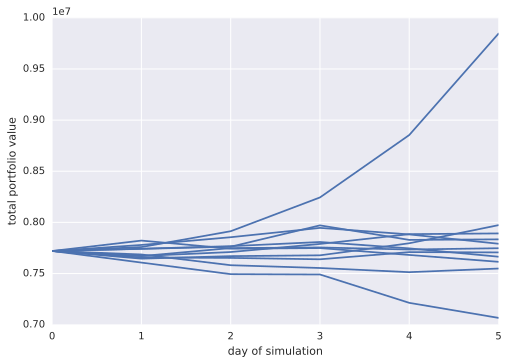

In [39]:
for c in walk_results:
    ax = sns.tsplot(c)

_ = ax.set(xlabel="day of simulation", ylabel="total portfolio value")

# Getting more realistic results

Of course, most real-world stock returns aren't normally distributed.  To make a more interesting simulation, we can try to find a distribution that better models the returns we've observed.

We'll start by looking at the actual distributions of returns.  The Seaborn `distplot` function will plot a histogram of returns and fit a [kernel density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation) to the observations.  To see this in action, we'll try it out first with a single security:

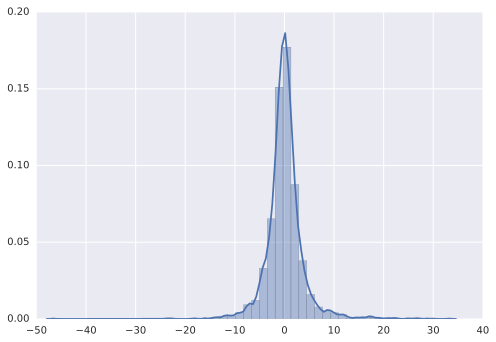

In [40]:
rdist = ddf.filter(ddf["ticker"] == "RHT").select("change").rdd.map(lambda r: r["change"]).filter(lambda c: c is not None).collect()
_ = sns.distplot(rdist)

As we can see, the distribution for this particular security doesn't look all that normal.  While there are various [statistical techniques to quantify](https://en.wikipedia.org/wiki/Goodness_of_fit) just how bad of a fit the normal distribution is for our observations (see in particular [this one](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)), `distplot` will let us visually compare an empirically-observed distribution to an ideal distribution in order to see how well the latter fits the former.  We can do this to see just how far this distribution is from normal.

We'll first import a library of models and then plot the expected return distribution if returns were normal:

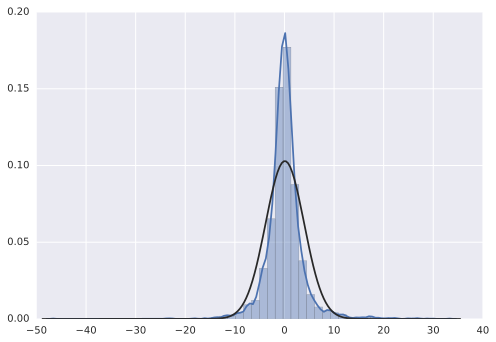

In [41]:
from scipy import stats
_ = sns.distplot(rdist, fit=stats.norm)

As we can see, the normal distribution (black line) is not a great fit for the kernel density estimate of our observations (blue line).  While we'd want a more rigorous way to choose models in a production application, looking at the returns from multiple securities is a good way to continue our exploration of these data.  We'll do that now.

First, we'll choose a small number of securities at random:

In [42]:
symbols = ddf.select("ticker").distinct().sample(True, 0.001).rdd.map(lambda l: l["ticker"]).collect()

Now we'll use Spark to generate a data frame with all of the returns for each symbol in `symbols`:

In [43]:
dfs = ddf.filter(ddf["ticker"].isin(symbols)).select("ticker", "change").dropna()
sampled_returns = dfs.toPandas()

Let's unpack what's happening here:

1.  We start with `ddf`, our `DataFrame` of stock returns.
2.  We're going to filter out any row that isn't for a symbol we care about.  In SQL, this would look like `SELECT ticker, change WHERE ticker IN ...`; in the Spark data frame DSL we use `isin`, like this:  `ddf["ticker"].isin(symbols)`.
3.  The return for the first day we have data for each ticker symbol will be null (by definition), and we don't want to have to deal with those in our plot functions.  The `dropna()` function is a convenient way to do this.
4.  Finally, we're going to collect the Spark data frame in memory and convert it to a Pandas data frame, which will make it easier to plot.

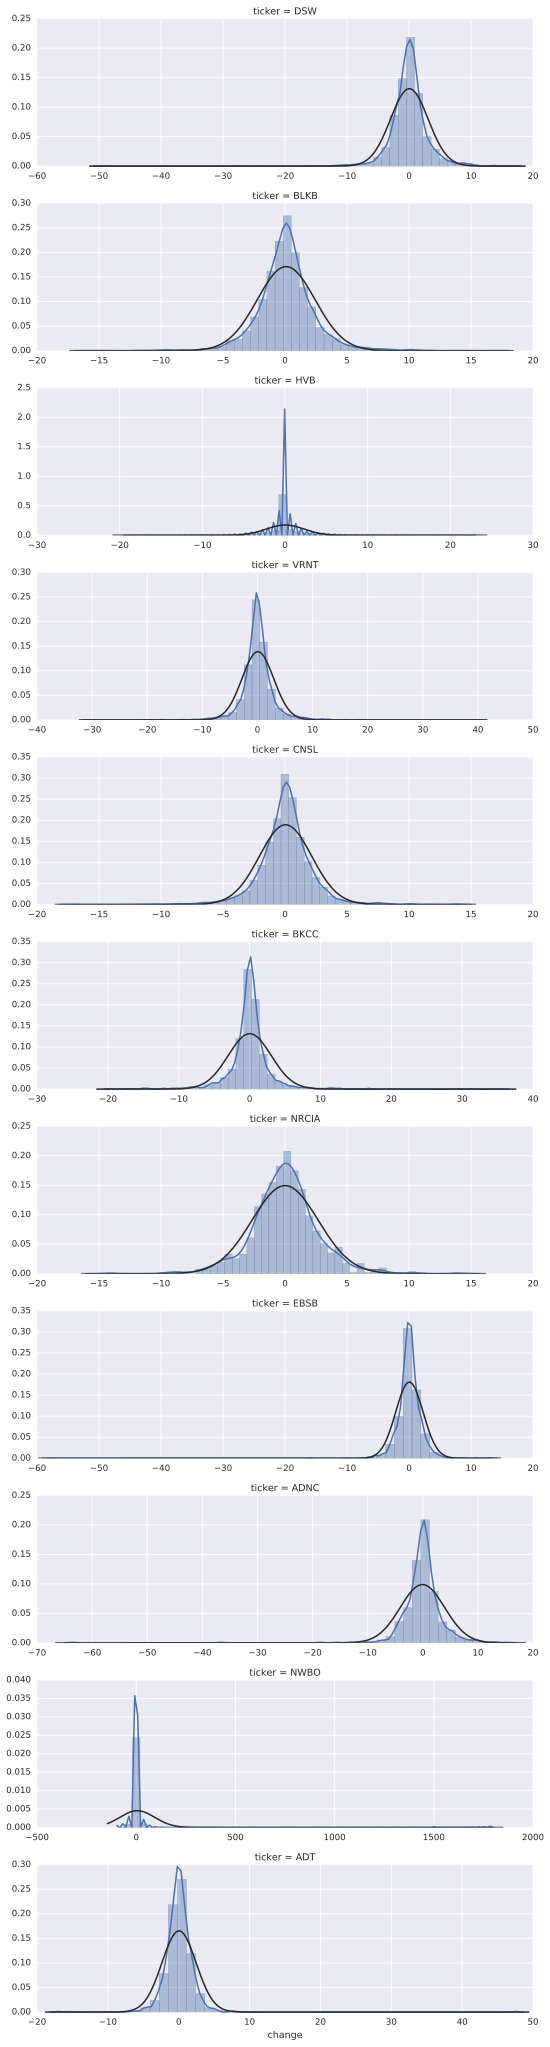

In [44]:
g = sns.FacetGrid(sampled_returns, row="ticker", sharex=False, sharey=False, aspect=3)
_ = g.map(sns.distplot, "change", fit=stats.norm)

You can re-run this experiment several times to see the results with a different set of sampled ticker symbols.

We have the intuition that the normal distribution isn't the best option, but it's easy to look for a better one.  Start by seeing [what distributions are available in the SciPy `stats` module](https://docs.scipy.org/doc/scipy/reference/stats.html):

In [64]:
dir(stats)

Now you can try some different distributions and see if one looks like a good option.  What distributions seem to be good fits?  With some more exploratory work, you're able to turn this example code into a more realistic simulation.

# Exercises

1.  Find a distribution that is a better fit for the stock returns data.
2.  Use this distribution to fit models to each ticker symbol and develop a new `simulate` method to sample from these distributions rather than from normal distributions.  Compare the results of this simulation to the results of the simulation
3.  &starf; Implement a goodness-of-fit test of your choice.
4.  Using the test you developed above, evaluate the distribution fits for every symbol.  Are there any particularly bad fits?
5.  &starf; Identify some additional distributions to use for modeling security returns that don't work well with the distribution you identified above.  Build a more sophisticated simulation that chooses one of several possible distributions for each security to find the best fit.
6.  &starf; Past performance is no guarantee of future results, but it's one of the best indicators we have.  Nevertheless, we should be careful.  What are some potential pitfalls and limitations of this general approach?